In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)
inspector = inspect(engine)
table_names = inspector.get_table_names()

In [6]:
# View all of the classes that automap found
#Base.classes.keys()
table_names

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
columns = inspector.get_columns('measurement')
#for col in columns:
#    print(col)

recent_date = session.query(measurement.date).order_by((measurement.date).desc()).first()
print(recent_date)

('2017-08-23',)


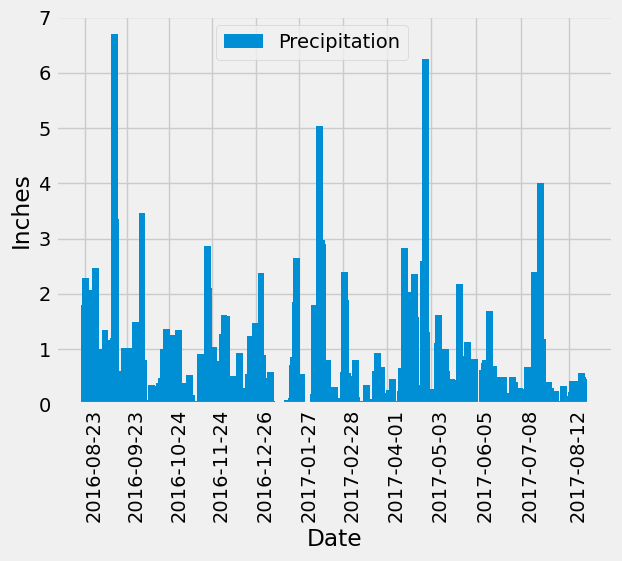

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = dt.datetime(2017, 8, 23)
# Calculate the date one year from the last date in data set.
start_date = last_date - dt.timedelta(days=366)
#print(start_date, last_date)


# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= start_date).filter(measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
scores_df = pd.DataFrame(scores, columns=["Date", "Inches"]).set_index("Date")

# Sort the dataframe by date
scores_df_desc = scores_df.sort_index(ascending=True)
scores_df_desc = scores_df_desc.dropna(how="any")


# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(scores_df_desc.index, scores_df_desc["Inches"], align="center", width=5)
plt.xticks(scores_df_desc.index[::180], rotation = 90,  rotation_mode='anchor', ha='right')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"], bbox_to_anchor=(0.65, 1))
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
scores_df_desc.describe()

,Inches
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
#columns2 = inspector.get_columns('station')
#for col in columns2:
#    print(col)
    
stations = session.query(func.count(station.station)).all()
print(stations)

[(9,)]


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_feq = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_feq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
act_station = station_feq[0][0]
#print(act_station)

min_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == act_station).all()
max_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == act_station).all()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == act_station).all()

print(min_temp, max_temp, avg_temp)

[(54.0,)] [(85.0,)] [(71.66378066378067,)]


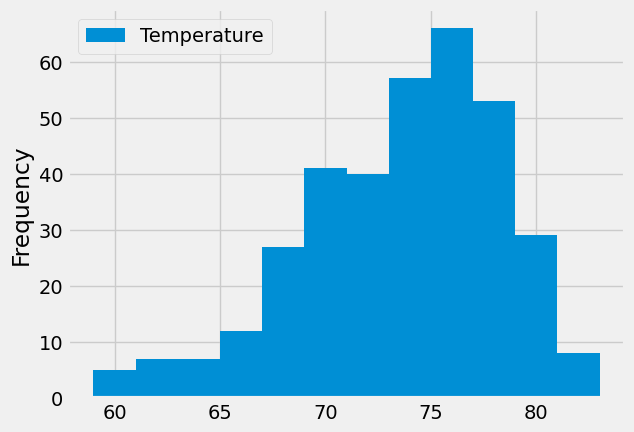

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_12_hist = session.query(measurement.date, measurement.tobs).filter(measurement.station == act_station).filter(measurement.date >= start_date).filter(measurement.date <= last_date).all()
temp_12_hist_df = pd.DataFrame(temp_12_hist, columns=["Date", "Temperature"]).set_index("Date")

graph = temp_12_hist_df.plot(kind='hist', bins=12)

# Close Session

In [24]:
# Close Session
session.close()